In [ ]:
# -------------------------------------------------------
#                  SCRIPT PRINCIPAL
#    Serveix per generar les gràfiques del teu membre.
#
#      Opcionalment també serveix per generar 
#       les gràfiques de l'ensemble mean si
#        es disposa del fitxer NetCDF 'em'
# -------------------------------------------------------

###
##Loading libraries
###

import numpy as np
import pandas as pd
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeaturefrom
import cartopy.feature as cfeature
from scipy.stats import t
from scipy import stats
import sys
import os


In [ ]:
###
# --------- CONFIGURACIÓ BÀSICA -------
###

# TRIA LA VARIABLE QUE VOLS ANALITZAR AQUÍ
variable='tas' # 'tas' o 'pr' (temperatura o precipitació)

# POSA EL TEU NÚMERO DE MEBRE AQUÍ
numMembre='18'

# -------------- OPCIONAL -------------

###
# SHOW VS SAVE PLOT
###
savePlot=True
# True --> guarda el plot a output_plots

###
# DIRECTORIES
###
sourceData='../member_data/'
outputDir='../output_plots/'

###
# ENSABLE MEAN?
###
ensembleMean=True
# Si disposes d'un fitxer a l'estil 'pr_Amon_IPSL-CM6A-LR_historical_emi1p1f1_gr_185001-201412.nc'
if ensembleMean: outputDir += 'ensemble_mean/'

In [402]:
###
##Selecting parameters
###
#Period
iyr=1850 # initial year
fyr=2014 # final year 
nyr=fyr-iyr+1 # number of year
#Season/month
season='annual'
imon=1
fmon=12
#Region
domain='global'
#Model and variable
model='IPSL-CM6A-LR'

# Generem el nom del fitxer a partir de la variable i el membre donats a la cel·la anterior (CONFIGURATION)
fileName=sourceData+variable+'_Amon_IPSL-CM6A-LR_historical_r'+numMembre+'i1p1f1_gr_185001-201412.nc'
member = 'r'+numMembre+'i1p1f1' # Per la resta de l'script

if ensembleMean:
    fileName = sourceData + variable + '_Amon_IPSL-CM6A-LR_historical_emi1p1f1_gr_185001-201412.nc'
    member = 'emi1p1f1'

In [403]:
###
##Opening
###
try:
    fh = Dataset(fileName, mode='r')
except FileNotFoundError:
    print(f"File {fileName} not found. Check the path and filename.")
    sys.exit()
field = fh.variables[variable][:]
units=fh.variables[variable].units
xlon = fh.variables['lon'][:]
# Shift longitude from 0-360 to -180 to 180 with Cartopy compatibility
xlon = np.where(xlon > 180, xlon - 360, xlon)
# Sort longitudes and corresponding data
sort_idx = np.argsort(xlon)
xlon = xlon[sort_idx]
field = field[..., :, sort_idx]

nlon = len(xlon)
ylat = fh.variables['lat'][:]
nlat = len(ylat)
time = fh.variables['time']
fh.close()

# Convert field to mm/day for precipitation
if variable == 'pr':
    field = field * 86400  # Convert kg/m²/s to mm/day
if variable == 'tas':
    field = field - 273.15  # Convert Kelvin to Celsius

In [405]:

###
##Selecting period
###
field=field[(12*(iyr-1850)):(12*(fyr+1-1850)),:,:]

#Monthly/season selection
value=np.zeros((nyr,nlat,nlon))
for i in range(nyr):
    tmp=field[12*i+(imon-1):12*i+(fmon),:,:]
    value[i,:,:]=np.mean(tmp,axis=0)

###
##Computing climatology and standard deviation
###
clim=np.zeros((nlat,nlon))
clim=np.ma.mean(value,axis=0)  
std=np.ma.std(value,axis=0)

<>:23: SyntaxWarning: invalid escape sequence '\c'
<>:23: SyntaxWarning: invalid escape sequence '\c'
C:\Users\PC\AppData\Local\Temp\ipykernel_17948\941252538.py:23: SyntaxWarning: invalid escape sequence '\c'
  cb_label = '$^{\circ}C$'


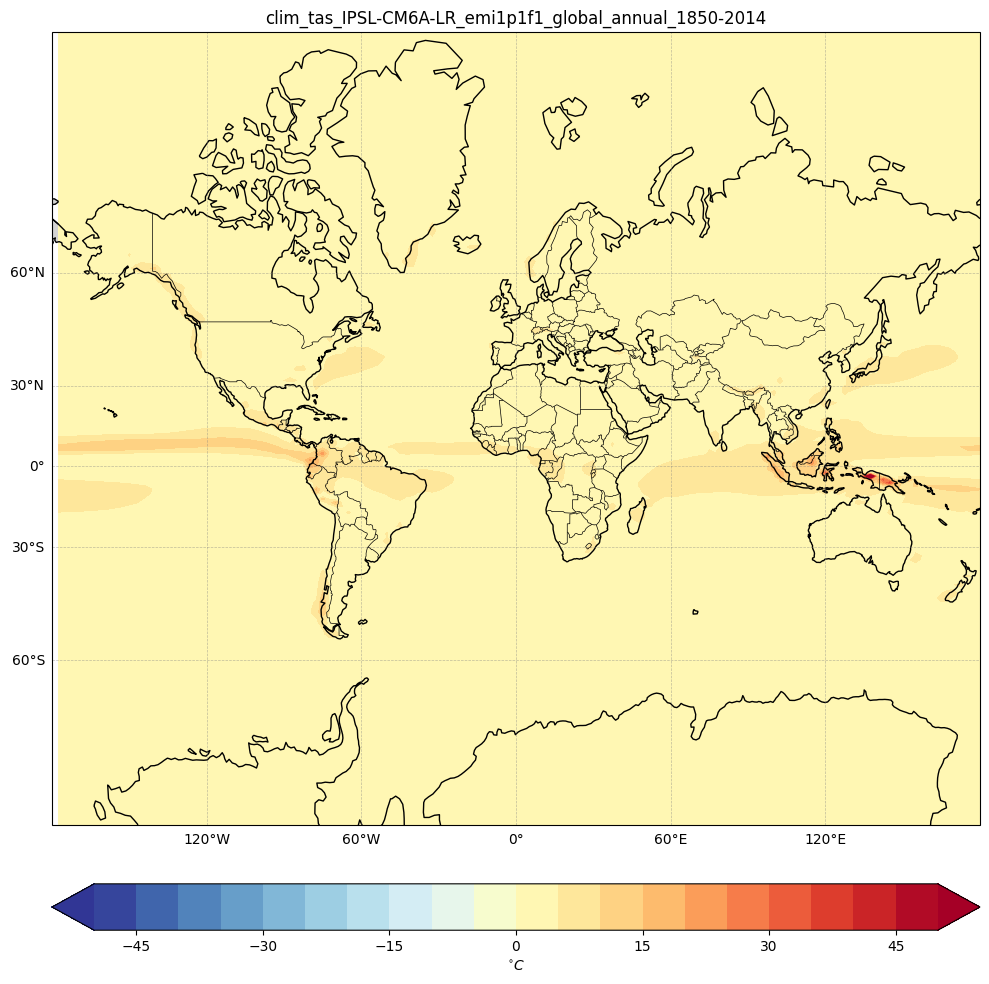

In [406]:
###
#Plotting climatology and standard deviation
###
fig = plt.figure(figsize=(10, 12))
ax = plt.axes(projection=ccrs.Mercator())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')

# Add gridlines with latitude and longitude labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False  # Disable top labels
gl.right_labels = False  # Disable right labels
gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}

# Adjust settings based on the variable
if variable == 'tas':  # Temperature
    clevs = np.arange(-50, 55, 5)
    cmap = plt.cm.RdYlBu_r
    cb_label = '$^{\circ}C$'
elif variable == 'pr':  # Precipitation
    cmap = plt.cm.Blues
    clim_data = clim[:, :] # Ja està en mm/day
    cb_label = 'mm/day'
    clevs = np.linspace(np.min(clim_data), np.max(clim_data), 20)

# Create meshgrid for plotting
lons, lats = np.meshgrid(xlon, ylat)

# Plot climatology
cf = ax.contourf(
    lons, lats, clim_data,
    clevs, cmap=cmap, extend='both',
    transform=ccrs.PlateCarree()
)

cb = plt.colorbar(cf, orientation="horizontal", pad=0.05, ax=ax)
cb.set_label(cb_label, fontsize=10)
domain = 'global' # La climatologia la fem global
plotname = 'clim_%s_%s_%s_%s_%s_%i-%i' % (variable, model, member, domain, season, iyr, fyr)
plt.title('%s' % (plotname), fontsize=12)
plt.tight_layout()
if savePlot: plt.savefig(outputDir + plotname + '.png', format='png', bbox_inches='tight')
plt.show()


In [408]:
###
##Computing anomalies
###
anom=np.zeros((nyr,nlat,nlon))
for i in range(nyr):
    anom[i,:,:]=value[i,:,:]-clim

###
##Computing detrended anomalies using different detrending methods ( linear, quadratic, cubic)
#Info: #---------------------
#https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html
#-----------------------------
###
##
deg=1
#deg=int(sys.argv[2])
anom_notrend=np.zeros((nyr,nlat,nlon))
xyears=np.arange(0,nyr,1)
for j in range(nlat):
    for i in range(nlon):
        if deg==1:
            poly=np.polyfit(xyears,anom[:,j,i],deg=1)
            anom_notrend[:,j,i]=anom[:,j,i]-(poly[0]*xyears+poly[1])
        elif deg==2:
            poly=np.polyfit(xyears,anom[:,j,i],deg=2)
            anom_notrend[:,j,i]=anom[:,j,i]-(poly[0]*xyears**2+poly[1]*xyears+poly[2])
        elif deg==3:
            poly=np.polyfit(xyears,anom[:,j,i],deg=3)
            anom_notrend[:,j,i]=anom[:,j,i]-(poly[0]*xyears**3+poly[1]*xyears**2+poly[2]*xyears+poly[3])

###
##Computing standard deviation of anomalies ( with or without trend)
###
stdnotrend=np.ma.std(anom_notrend,axis=0)


<>:26: SyntaxWarning: invalid escape sequence '\c'
<>:26: SyntaxWarning: invalid escape sequence '\c'
C:\Users\PC\AppData\Local\Temp\ipykernel_17948\2539559654.py:26: SyntaxWarning: invalid escape sequence '\c'
  cb_label = '$^{\circ}C$'  # Celsius


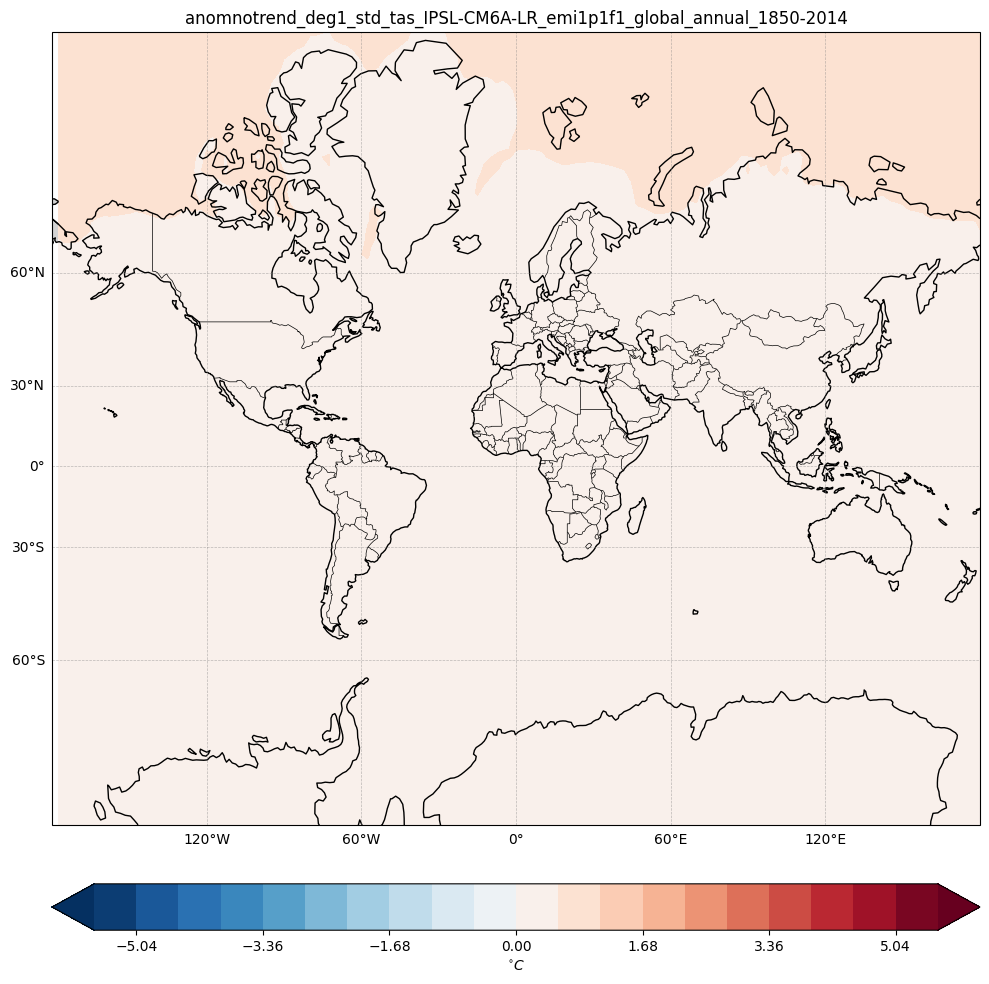

In [409]:
###
##Plotting standard deviation of anomalies
###
fig = plt.figure(figsize=(10, 12))
ax = plt.axes(projection=ccrs.Mercator())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')

# Add gridlines with latitude and longitude labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False  # Disable top labels
gl.right_labels = False  # Disable right labels
gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}

# Create meshgrid for plotting
lons, lats = np.meshgrid(xlon, ylat)

# Adjust settings based on the variable
if variable == 'tas':  # Temperature
    clevs = np.linspace(-5.6, 5.6, 21)  # Standard deviation levels for temperature
    cmap = plt.cm.RdBu_r  # Diverging colormap for temperature
    cb_label = '$^{\circ}C$'  # Celsius
elif variable == 'pr':  # Precipitation
    cmap = plt.cm.RdBu  # Sequential colormap for precipitation
    cb_label = 'mm/day'  # Millimeters per day
    clevs = np.linspace(-8.0, 8.0, 21)
    if ensembleMean: clevs = np.linspace(-3.0, 3.0, 21)

# Plot standard deviation of anomalies
cf = ax.contourf(
    lons, lats, stdnotrend[:, :],
    clevs, cmap=cmap, extend='both',
    transform=ccrs.PlateCarree()
)

cb = plt.colorbar(cf, orientation="horizontal", pad=0.05, ax=ax)
cb.set_label(cb_label, fontsize=10)
domain = 'global' # La desviació estàndard la fem global
plotname = 'anomnotrend_deg%i_std_%s_%s_%s_%s_%s_%i-%i' % (deg, variable, model, member, domain, season, iyr, fyr)
plt.title('%s' % (plotname), fontsize=12)
plt.tight_layout()
if savePlot: plt.savefig(outputDir + plotname + '.png', format='png', bbox_inches='tight')
plt.show()

In [410]:
###
## Computing spatial trend
###

trend=np.empty((nlat,nlon))
intercept=np.empty((nlat,nlon))
pvalue=np.empty((nlat,nlon))
rvalue=np.empty((nlat,nlon))
stderr=np.empty((nlat,nlon))
xd=np.array(range((nyr)))

for j in range(nlat):
    for i in range(nlon):
        yd=anom[:,j,i]
        par = stats.linregress(xd, yd)
        stderr[j,i]=par[4]
        pvalue[j,i]=par[3]
        rvalue[j,i]=par[2]
        intercept[j,i]=par[1]
        trend[j,i]=par[0]

# Create meshgrid for plotting
lons, lats = np.meshgrid(xlon, ylat)
# Convert trend to decade
trend = trend * 10

<>:25: SyntaxWarning: invalid escape sequence '\c'
<>:25: SyntaxWarning: invalid escape sequence '\c'
C:\Users\PC\AppData\Local\Temp\ipykernel_17948\940111445.py:25: SyntaxWarning: invalid escape sequence '\c'
  cb_label = '$^{\circ}C$/decade'


Maximum absolute trend value: 0.5249294817751797


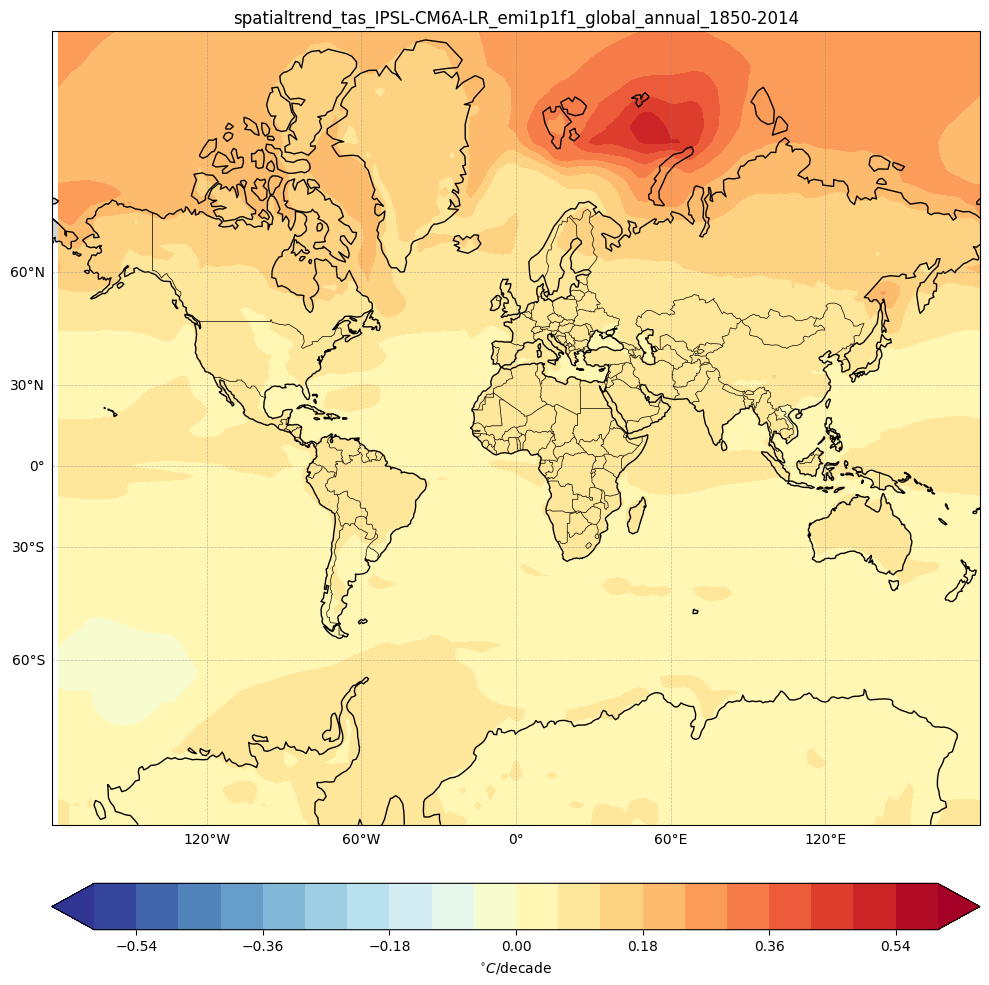

In [411]:
###
##Plotting spatial trend
###
fig = plt.figure(figsize=(10, 12))
ax = plt.axes(projection=ccrs.Mercator())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')

# Add gridlines with latitude and longitude labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False  # Disable top labels
gl.right_labels = False  # Disable right labels
gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}

# Adjust settings based on the variable
if variable == 'tas':  # Temperature
    absmax = np.nanmax(np.abs(trend))  # Per saber el rang de temperatures de la colorbar
    clevs = np.linspace(-0.6, 0.6, 21)
    print(f"Maximum absolute trend value: {absmax}")
    cmap = plt.cm.RdYlBu_r  # Diverging colormap for temperature
    cb_label = '$^{\circ}C$/decade'
elif variable == 'pr':  # Precipitation
    clevs = np.linspace(-0.5, 0.5, 21)
    cmap = plt.cm.RdBu
    cb_label = 'mm/day/decade'  # Millimeters per day

# Plot standard deviation of anomalies
cf = ax.contourf(
    lons, lats, trend[:, :],
    clevs, cmap=cmap, extend='both',
    transform=ccrs.PlateCarree()
)

cb = plt.colorbar(cf, orientation="horizontal", pad=0.05, ax=ax)
cb.set_label(cb_label, fontsize=10)
domain = 'global' # El spatial trend el fem global
plotname = 'spatialtrend_%s_%s_%s_%s_%s_%i-%i' % (variable, model, member, domain, season, iyr, fyr)
plt.title('%s' % (plotname), fontsize=12)
plt.tight_layout()
if savePlot: plt.savefig(outputDir + plotname + '.png', format='png', bbox_inches='tight')
plt.show()


<>:30: SyntaxWarning: invalid escape sequence '\c'
<>:30: SyntaxWarning: invalid escape sequence '\c'
C:\Users\PC\AppData\Local\Temp\ipykernel_17948\180366928.py:30: SyntaxWarning: invalid escape sequence '\c'
  ylabel = '%s (%s)' % (variable, '$^{\circ}C$')
C:\Users\PC\AppData\Local\Temp\ipykernel_17948\180366928.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


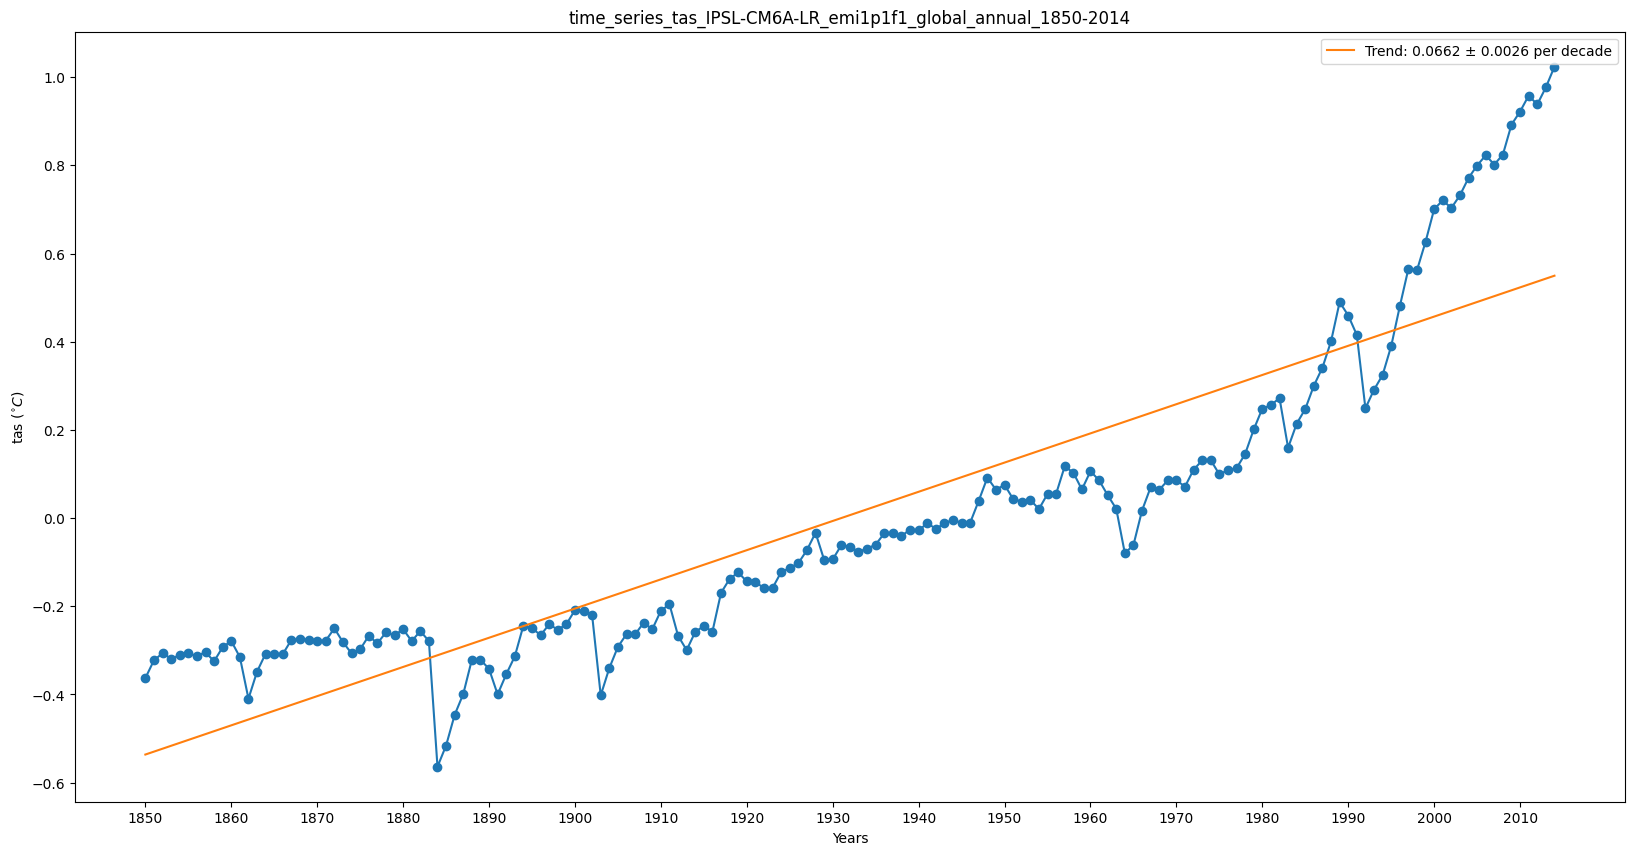

In [412]:
####Spatial average

wgts = np.cos(np.deg2rad(ylat))

ts_anoms=np.ma.average(np.ma.average(anom,axis=1,weights=wgts),axis=1)  #average in longitude spave_field.shape=(time)
ts_anoms_notrend=np.ma.average(np.ma.average(anom_notrend,axis=1,weights=wgts),axis=1)

xd=np.array(range(nyr))
par = stats.linregress(xd,ts_anoms)
trend=par[0]
intercept=par[1]
rvalue=par[2]
pvalue=par[3]
stderr=par[4]

###
##Plotting time series (GLOBAL)
###

fig=plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)
xdplot=xd+1
my_ticks=np.arange(iyr,fyr+1,1)
frequency=10
#plt.ylim(0,100)


# Adjust y-axis label based on the variable
if variable == 'tas':
    ylabel = '%s (%s)' % (variable, '$^{\circ}C$')
elif variable == 'pr':
    ylabel = '%s (%s)' % (variable, 'mm/day')
plt.ylabel(ylabel)
plt.xlabel('Years')
plt.legend()

plt.xticks(xdplot[::frequency],my_ticks[::frequency])
plt.plot(xdplot,ts_anoms,linestyle='-',marker='o')
plt.plot(xdplot, trend * xdplot + intercept, label='Trend: %1.4f ± %1.4f per decade' % (10 * trend, 10 * stderr))
plt.legend()

if savePlot: plt.savefig(outputDir + plotname + '.png', format='png', bbox_inches='tight')
domain = 'global'  # Evolució temporal de les anomalies - Global (dp fem EuroMed)
plotname='time_series_%s_%s_%s_%s_%s_%i-%i' %(variable,model,member,domain,season,iyr,fyr)
plt.title(plotname,fontsize=12)
if savePlot: plt.savefig(outputDir + plotname + '.png', format='png', bbox_inches='tight')
plt.show()


In [413]:
###
##Selecting a different domain
###
#domain:EuroMed
#longitude: 10W-40E; latitude: 30N-50N
#in Python: x[70:89]; y[92:110]
###

domain='EuroMed'
xi=70;xf=89
xlon_dom=xlon[xi:xf]
nlon_dom=len(xlon_dom)
yi=92;yf=110
ylat_dom=ylat[yi:yf]
nlat_dom=len(ylat_dom)

#value_dom=value[:,yi:yf,xi:xf,:]
anom_dom=anom[:,yi:yf,xi:xf]
anom_notrend_dom=anom_notrend[:,yi:yf,xi:xf]

wgts = np.cos(np.deg2rad(ylat_dom))

ts_anoms_dom=np.ma.average(np.ma.average(anom_dom,axis=1,weights=wgts),axis=1)  #average in longitude spave_field.shape=(time)
ts_anoms_notrend_dom=np.ma.average(np.ma.average(anom_notrend_dom,axis=1,weights=wgts),axis=1)


xd=np.array(range(nyr))
par_dom = stats.linregress(xd,ts_anoms_dom)
trend_dom=par_dom[0]
intercept_dom=par_dom[1]
rvalue_dom=par_dom[2]
pvalue_dom=par_dom[3]
stderr_dom=par_dom[4]


<>:13: SyntaxWarning: invalid escape sequence '\c'
<>:13: SyntaxWarning: invalid escape sequence '\c'
C:\Users\PC\AppData\Local\Temp\ipykernel_17948\3920785666.py:13: SyntaxWarning: invalid escape sequence '\c'
  ylabel = '%s (%s)' % (variable, '$^{\circ}C$')


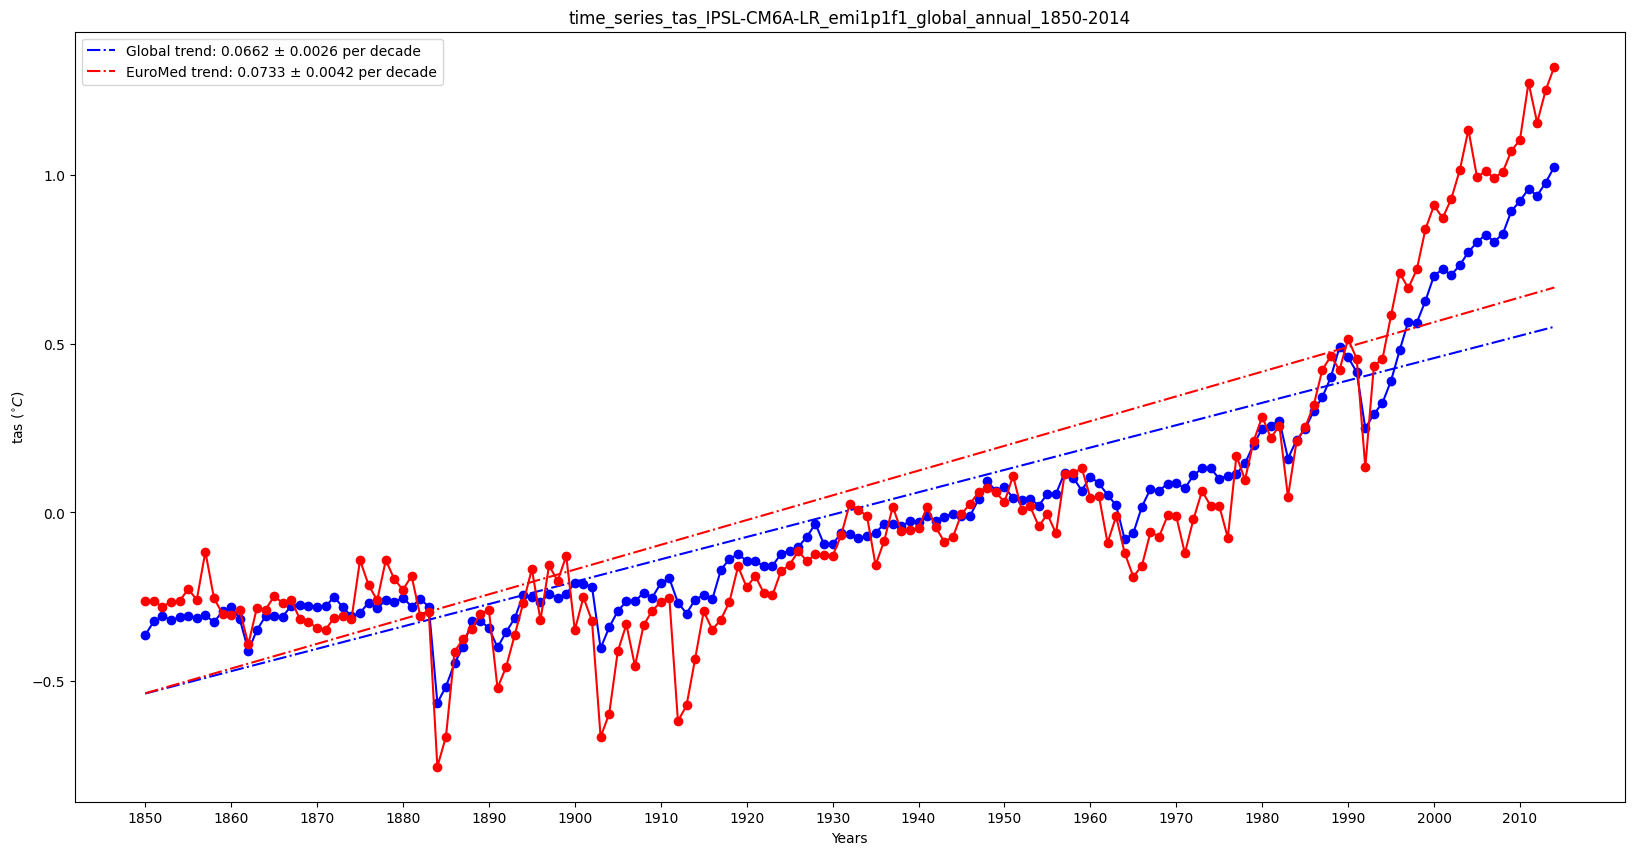

In [414]:

###
##Plotting time series (EURO-MED)
###

fig=plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)
xdplot=xd+1
my_ticks=np.arange(iyr,fyr+1,1)
frequency=10
#plt.ylim(0,100)

if variable == 'tas':
    ylabel = '%s (%s)' % (variable, '$^{\circ}C$')
elif variable == 'pr':
    ylabel = '%s (%s)' % (variable, 'mm/day')
plt.ylabel(ylabel)
plt.xlabel('Years')
plt.xticks(xdplot[::frequency],my_ticks[::frequency])
plt.title(plotname,fontsize=12)
plt.plot(xdplot,ts_anoms,linestyle='-',marker='o',color='blue')

plt.plot(xdplot,trend*xdplot+intercept,linestyle='-.',color='blue',label='Global trend'+': %1.4f ± %1.4f per decade'%(10*trend,10*stderr))

plt.plot(xdplot,ts_anoms_dom,linestyle='-',marker='o',color='red')
plt.plot(xdplot,trend_dom*xdplot+intercept,linestyle='-.',color='red',label=domain+' trend: %1.4f ± %1.4f per decade'%(10*trend_dom,10*stderr_dom))
plotname='time_series_%s_%s_%s_%s_%s_%i-%i' %(variable,model,member,domain,season,iyr,fyr)

plt.legend()
if savePlot: plt.savefig(outputDir + plotname + '.png', format='png', bbox_inches='tight')
plt.show()